In [1]:
import sys, os
from pyprojroot import here


# spyder up to find the root

local = here(project_files=[".local"])

# append to path
sys.path.append(str(local))

In [17]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
import optax
import equinox as eqx
from einops import rearrange
import numpy as np
import xarray as xr
import pandas as pd

import tqdm.notebook as tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import hvplot.xarray
import hvplot.pandas
from xmovie import Movie

from src.utils import get_meshgrid, calculate_gradient, calculate_laplacian
from src.mlp import MLPNet
from src.siren import SirenNet

from src.data import make_mini_batcher
from src.viz import create_movie

import wandb

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# wandb.init(
#     tags=["eda"],
#     project="nerf4ssh",
#     entity="ige",
#     dir=local,
# )

# smoke_test = False
# wandb.config.update({"smoke_test": smoke_test})

## Model Data

In [4]:
model = "ssh"

ds = xr.open_dataset("/mnt/meom/workdir/johnsonj/data/ssh_data/interim_gulf/model.nc")
ds = ds.sortby("time")
ds

<xarray.Dataset>
Dimensions:    (latitude: 48, longitude: 48, time: 1826)
Coordinates:
  * latitude   (latitude) float64 32.12 32.38 32.62 32.88 ... 43.38 43.62 43.88
  * longitude  (longitude) float64 294.1 294.4 294.6 294.9 ... 305.4 305.6 305.9
  * time       (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2019-12-31
Data variables:
    sla        (time, latitude, longitude) float64 ...
    adt        (time, latitude, longitude) float64 ...
Attributes:
    FileType:      GRID_DOTS
    OriginalName:  dt_upd_global_merged_msla_h_20150101_20150101_20210409.nc
    CreatedBy:     pva_axp@node065.sis.cnes.fr
    CreatedOn:     09-APR-2021 17:15:56:000000
    title:         SSALTO/DUACS - DT MSLA - Merged Product - Up-to-date Globa...
    history:       2021/04/09 17:15:56 pva_axp@node065.sis.cnes.fr Import dep...

In [37]:
import pyinterp

In [43]:
# create axis
lon_axis = pyinterp.Axis(ds["longitude"][:].data, is_circle=True)
lat_axis = pyinterp.Axis(ds["latitude"][:].data)
t_axis = pyinterp.TemporalAxis(ds["time"][:].data)

In [45]:
# get data variable
var = ds["sla"].transpose("longitude", "latitude", "time").data

In [46]:
grid = pyinterp.Grid3D(lon_axis, lat_axis, t_axis, var)

In [48]:
ds_obs = xr.open_dataset("/mnt/meom/workdir/johnsonj/data/ssh_data/interim_gulf/test.nc")
ds_obs = ds_obs.sortby("time")
ds_obs

<xarray.Dataset>
Dimensions:         (time: 397123)
Coordinates:
  * time            (time) datetime64[ns] 2015-01-01T09:53:30.174402048 ... 2...
    longitude       (time) float64 ...
    latitude        (time) float64 ...
Data variables:
    sla_unfiltered  (time) float32 ...

In [5]:
ds_obs = xr.open_dataset("/mnt/meom/workdir/johnsonj/data/ssh_data/interim_gulf/test.nc")
ds_obs = ds_obs.sortby("time")
ds_winter = ds.sel(time=slice("2015-12-01", "2016-03-01"))
ds_summer = ds.sel(time=slice("2016-06-01", "2016-09-01"))

In [62]:
# interpolate maps onto along track dataset
obs_interp = pyinterp.trivariate(
    grid,
    ds_obs.longitude.values,
    ds_obs.latitude.values,
    t_axis.safe_cast(ds_obs.time.values),
    bounds_error=False
    # ds_obs.sla_unfiltered.values
)
print(obs_interp.shape)
# obs_interp = obs_interp.reshape(ds_obs.longitude.values.shape)
# obs_interp.shape

(397123,)


In [66]:
obs_interp

array([       nan,        nan, 0.26007817, ...,        nan,        nan,
              nan])

In [18]:
ds_winter = ds.sel(time=slice("2015-12-01", "2016-03-01"))
ds_summer = ds.sel(time=slice("2016-06-01", "2016-09-01"))
ds_winter

<xarray.Dataset>
Dimensions:    (latitude: 48, longitude: 48, time: 92)
Coordinates:
  * latitude   (latitude) float64 32.12 32.38 32.62 32.88 ... 43.38 43.62 43.88
  * longitude  (longitude) float64 294.1 294.4 294.6 294.9 ... 305.4 305.6 305.9
  * time       (time) datetime64[ns] 2015-12-01 2015-12-02 ... 2016-03-01
Data variables:
    sla        (time, latitude, longitude) float64 ...
    adt        (time, latitude, longitude) float64 ...
Attributes:
    FileType:      GRID_DOTS
    OriginalName:  dt_upd_global_merged_msla_h_20150101_20150101_20210409.nc
    CreatedBy:     pva_axp@node065.sis.cnes.fr
    CreatedOn:     09-APR-2021 17:15:56:000000
    title:         SSALTO/DUACS - DT MSLA - Merged Product - Up-to-date Globa...
    history:       2021/04/09 17:15:56 pva_axp@node065.sis.cnes.fr Import dep...

In [13]:
# ds.to_dataframe().reset_index().set_index("longitude", "latitude", "time").to_xarray()

In [15]:
create_movie(ds_winter.sla, framedim="time", name="ssh_gulf_djf_duacs")
create_movie(ds_winter.sla, framedim="time", name="ssh_gulf_djf_duacs")

/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/92 [00:00<?, ?it/s]

Movie created at movie_ssh_gulf_djf_duacs.mp4
GIF created at plots/movie_ssh_gulf_djf_duacs.gif


In [19]:
create_movie(ds_summer.sla, framedim="time", name="ssh_gulf_jja_duacs")

/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/93 [00:00<?, ?it/s]

Movie created at movie_ssh_gulf_jja_duacs.mp4
GIF created at plots/movie_ssh_gulf_jja_duacs.gif


In [20]:
ds_winter.sla.hvplot.image(x="longitude", y="latitude", width=500, height=400, cmap="RdBu_r", title="DUACs Model")

:DynamicMap   [time]
   :Image   [longitude,latitude]   (sla)

In [21]:
ds_summer.sla.hvplot.image(x="longitude", y="latitude", width=500, height=400, cmap="RdBu_r", title="DUACs Model")

:DynamicMap   [time]
   :Image   [longitude,latitude]   (sla)

### Gradients

In [28]:
%%time
ds_winter["sla_grad"] = calculate_gradient(ds_winter.sla, "longitude", "latitude")
ds_summer["sla_grad"] = calculate_gradient(ds_summer.sla, "longitude", "latitude")

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 15.8 ms


In [31]:
create_movie(ds_winter.sla_grad, framedim="time", name="ssh_gulf_djf_duacs_grad")
create_movie(ds_summer.sla_grad, framedim="time", name="ssh_gulf_jja_duacs_grad")

/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/93 [00:00<?, ?it/s]

Movie created at movie_ssh_gulf_jja_duacs_grad.mp4
GIF created at plots/movie_ssh_gulf_jja_duacs_grad.gif


In [29]:
ds_winter.sla_grad.hvplot.image(x="longitude", y="latitude", width=500, height=400, cmap="RdBu_r", title="DUACs Model (Gradient)")

:DynamicMap   [time]
   :Image   [longitude,latitude]   (sla_grad)

In [30]:
ds_summer.sla_grad.hvplot.image(x="longitude", y="latitude", width=500, height=400, cmap="RdBu_r", title="DUACs Model (Gradient)")

:DynamicMap   [time]
   :Image   [longitude,latitude]   (sla_grad)

### Laplacian

In [32]:
%%time
ds_winter["sla_lap"] = calculate_laplacian(ds_winter.sla, "longitude", "latitude")
ds_summer["sla_lap"] = calculate_laplacian(ds_summer.sla, "longitude", "latitude")

CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 25.6 ms


In [35]:
create_movie(ds_winter.sla_lap, framedim="time", name="ssh_gulf_djf_duacs_lap")
create_movie(ds_summer.sla_lap, framedim="time", name="ssh_gulf_jja_duacs_lap")

/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/92 [00:00<?, ?it/s]

Movie created at movie_ssh_gulf_djf_duacs_lap.mp4
GIF created at plots/movie_ssh_gulf_djf_duacs_lap.gif


/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


  0%|          | 0/93 [00:00<?, ?it/s]

Movie created at movie_ssh_gulf_jja_duacs_lap.mp4
GIF created at plots/movie_ssh_gulf_jja_duacs_lap.gif


In [33]:
ds_winter.sla_lap.hvplot.image(x="longitude", y="latitude", width=500, height=400, cmap="RdBu_r", title="DUACs Model (Laplacian)")

:DynamicMap   [time]
   :Image   [longitude,latitude]   (sla_lap)

In [34]:
ds_summer.sla_lap.hvplot.image(x="longitude", y="latitude", width=500, height=400, cmap="RdBu_r", title="DUACs Model (Laplacian)")

:DynamicMap   [time]
   :Image   [longitude,latitude]   (sla_lap)

In [68]:
ds_winter

<xarray.Dataset>
Dimensions:    (latitude: 48, longitude: 48, time: 92)
Coordinates:
  * latitude   (latitude) float64 32.12 32.38 32.62 32.88 ... 43.38 43.62 43.88
  * longitude  (longitude) float64 294.1 294.4 294.6 294.9 ... 305.4 305.6 305.9
  * time       (time) datetime64[ns] 2015-12-01 2015-12-02 ... 2016-03-01
Data variables:
    sla        (time, latitude, longitude) float64 0.2257 0.2167 ... 0.08938
    adt        (time, latitude, longitude) float64 ...
    sla_grad   (time, latitude, longitude) float64 0.0007315 ... 0.005626
    sla_lap    (time, latitude, longitude) float64 0.05235 0.03063 ... 0.00502
Attributes:
    FileType:      GRID_DOTS
    OriginalName:  dt_upd_global_merged_msla_h_20150101_20150101_20210409.nc
    CreatedBy:     pva_axp@node065.sis.cnes.fr
    CreatedOn:     09-APR-2021 17:15:56:000000
    title:         SSALTO/DUACS - DT MSLA - Merged Product - Up-to-date Globa...
    history:       2021/04/09 17:15:56 pva_axp@node065.sis.cnes.fr Import dep...

In [71]:
%%time

ds_winter.to_netcdf("/mnt/meom/workdir/johnsonj/data/ssh_data/interim_gulf_winter/model.nc")

CPU times: user 16 ms, sys: 8 ms, total: 24 ms
Wall time: 54.8 ms


In [72]:
%%time

ds_summer.to_netcdf("/mnt/meom/workdir/johnsonj/data/ssh_data/interim_gulf_summer/model.nc")

CPU times: user 20 ms, sys: 8 ms, total: 28 ms
Wall time: 129 ms


### Train Data

In [6]:
ds_train_obs = xr.open_dataset("/mnt/meom/workdir/johnsonj/data/ssh_data/interim_gulf/train.nc")
ds_train_obs = ds_train_obs.sortby("time")


In [7]:
ds_train_obs_winter = ds_train_obs.sel(time=slice("2015-12-01", "2016-03-01"))
ds_train_obs_summer = ds_train_obs.sel(time=slice("2016-06-01", "2016-09-01"))

In [74]:
%%time

ds_train_obs_winter.to_netcdf("/mnt/meom/workdir/johnsonj/data/ssh_data/interim_gulf_winter/train.nc")

CPU times: user 7.7 s, sys: 32 ms, total: 7.74 s
Wall time: 9.11 s


<timed eval>:1: SerializationWarning: saving variable longitude with floating point data as an integer dtype without any _FillValue to use for NaNs
<timed eval>:1: SerializationWarning: saving variable latitude with floating point data as an integer dtype without any _FillValue to use for NaNs


In [75]:
%%time

ds_train_obs_summer.to_netcdf("/mnt/meom/workdir/johnsonj/data/ssh_data/interim_gulf_summer/train.nc")

CPU times: user 10.3 s, sys: 0 ns, total: 10.3 s
Wall time: 10.4 s


<timed eval>:1: SerializationWarning: saving variable longitude with floating point data as an integer dtype without any _FillValue to use for NaNs
<timed eval>:1: SerializationWarning: saving variable latitude with floating point data as an integer dtype without any _FillValue to use for NaNs


### Test Data

In [8]:
ds_test_obs = xr.open_dataset("/mnt/meom/workdir/johnsonj/data/ssh_data/interim_gulf/test.nc")
ds_test_obs = ds_train_obs.sortby("time")
ds_test_obs_winter = ds_test_obs.sel(time=slice("2015-12-01", "2016-03-01"))
ds_test_obs_summer = ds_test_obs.sel(time=slice("2016-06-01", "2016-09-01"))

In [77]:
%%time

ds_test_obs_winter.to_netcdf("/mnt/meom/workdir/johnsonj/data/ssh_data/interim_gulf_winter/test.nc")

CPU times: user 7.56 s, sys: 0 ns, total: 7.56 s
Wall time: 7.62 s


<timed eval>:1: SerializationWarning: saving variable longitude with floating point data as an integer dtype without any _FillValue to use for NaNs
<timed eval>:1: SerializationWarning: saving variable latitude with floating point data as an integer dtype without any _FillValue to use for NaNs


In [78]:
%%time

ds_test_obs_summer.to_netcdf("/mnt/meom/workdir/johnsonj/data/ssh_data/interim_gulf_summer/test.nc")

CPU times: user 10.1 s, sys: 0 ns, total: 10.1 s
Wall time: 10.2 s


<timed eval>:1: SerializationWarning: saving variable longitude with floating point data as an integer dtype without any _FillValue to use for NaNs
<timed eval>:1: SerializationWarning: saving variable latitude with floating point data as an integer dtype without any _FillValue to use for NaNs


## Interpolation

In [293]:
df_test_obs_summer = ds_test_obs_summer.to_dataframe().reset_index().dropna()
df_test_obs_summer.describe()

,longitude,latitude,sla_unfiltered
count,70946.000000,70946.000000,70946.000000
mean,300.127320,37.978210,0.136737
std,3.444839,3.450950,0.247947
min,294.000286,32.000778,-1.047000
25%,297.158383,34.998487,0.033000
50%,300.209843,37.957117,0.143000
75%,303.116011,40.967899,0.249000
max,305.999258,43.999977,1.131000


In [294]:
df_test_obs_summer.hvplot.scatter(x="longitude", y="latitude", datashade=True)

:DynamicMap   []
   :RGB   [longitude,latitude]   (R,G,B,A)

In [296]:
from xhistogram.xarray import histogram

In [298]:
lon_bins = ds_summer.longitude.data
lat_bins = ds_summer.latitude.data
norm = histogram(
    ds_test_obs_summer.longitude, 
    ds_test_obs_summer.latitude, 
    bins=[lon_bins, lat_bins],
    weights=ds_test_obs_summer.sla_unfiltered
)

In [349]:
lon_bins = ds_summer.longitude.data
lat_bins = ds_summer.latitude.data
time_bins = ds_summer.time.data.astype(np.float64)
norm = histogram(
    ds_test_obs.longitude, 
    ds_test_obs.latitude, 
    ds_test_obs.time.astype(np.float64),
    bins=[lon_bins, lat_bins, time_bins],
    weights=ds_test_obs.sla_unfiltered,
    
)
# norm = np.sqrt(norm)
# norm = norm.where(norm > 0)


In [353]:
ds_summer

<xarray.Dataset>
Dimensions:    (latitude: 48, longitude: 48, time: 93)
Coordinates:
  * time       (time) datetime64[ns] 2016-06-01 2016-06-02 ... 2016-09-01
  * latitude   (latitude) float64 32.12 32.38 32.62 32.88 ... 43.38 43.62 43.88
  * longitude  (longitude) float64 294.1 294.4 294.6 294.9 ... 305.4 305.6 305.9
Data variables:
    sla        (time, latitude, longitude) float64 0.03442 0.03972 ... 0.1244
    adt        (time, latitude, longitude) float64 ...
    sla_grad   (time, latitude, longitude) float64 0.003422 ... 0.001681
    sla_lap    (time, latitude, longitude) float64 0.0009892 ... 0.0003708
Attributes:
    FileType:      GRID_DOTS
    OriginalName:  dt_upd_global_merged_msla_h_20150101_20150101_20210409.nc
    CreatedBy:     pva_axp@node065.sis.cnes.fr
    CreatedOn:     09-APR-2021 17:15:56:000000
    title:         SSALTO/DUACS - DT MSLA - Merged Product - Up-to-date Globa...
    history:       2021/04/09 17:15:56 pva_axp@node065.sis.cnes.fr Import dep...

In [9]:
dt = ds_summer.time.data[1] - ds_summer.time.data[0]

In [10]:
for i, itime in enumerate(ds_summer.time.data):
    print(i, itime)
    
    # find indices 
    indx = np.where(
        (
            np.abs(ds_test_obs_summer.time.values - ds_summer.time.values[i]) <= dt
        )
    )[0]
    
    # subset data
    lat = ds_test_obs_summer.latitude.values[indx]
    lon = ds_test_obs_summer.longitude.values[indx]
    data = ds_test_obs_summer.sla_unfiltered.values[indx]
    
    
    # do scatter plot
    ax = fig.subplots()
    
    ax.scatter(lon, lat, cmap=data)
    ax.set_title("")
    ax.set_facecolor("0.5")
    ax.set_aspect(1)
    
    
    # do 
    
    
    
    
    
    break

0 2016-06-01T00:00:00.000000000


NameError: name 'fig' is not defined

In [28]:
def custom_plotfunc(ds, fig, tt, *args, **kwargs):
    
    # find indices 
    indx = np.where(
        (
            np.abs(ds_test_obs_summer.time.values - ds.time.values[tt]) <= dt
        )
    )[0]
    
    # subset data
    lat = ds_test_obs_summer.latitude.values[indx]
    lon = ds_test_obs_summer.longitude.values[indx]
    data = ds_test_obs_summer.sla_unfiltered.values[indx]
    
    vmin = ds_test_obs_summer.sla_unfiltered.min()
    vmax = ds_test_obs_summer.sla_unfiltered.max()
    
    # do scatter plot
    ax = fig.add_subplot(111, aspect='equal')
    
    pts = ax.scatter(
        lon, lat, c=data, 
        cmap="RdBu_r", 
        vmin=ds_test_obs_summer.sla_unfiltered.min(), 
        vmax=ds_test_obs_summer.sla_unfiltered.max()
    )
    ax.set_title("")
    ax.set_facecolor("0.5")
    ax.set_aspect(0.75)
    ax.set(
        xlim=[
            ds.longitude.values.min()-0.5,
            ds.longitude.values.max()+0.5
        ],
        ylim=[
            ds.latitude.values.min()-0.5,
            ds.latitude.values.max()+0.5,
        ]
    )
    plt.colorbar(pts)
    # plt.tight_layout()
    
    return None, None

In [29]:
mov_custom = Movie(ds_summer.sla, custom_plotfunc)

/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


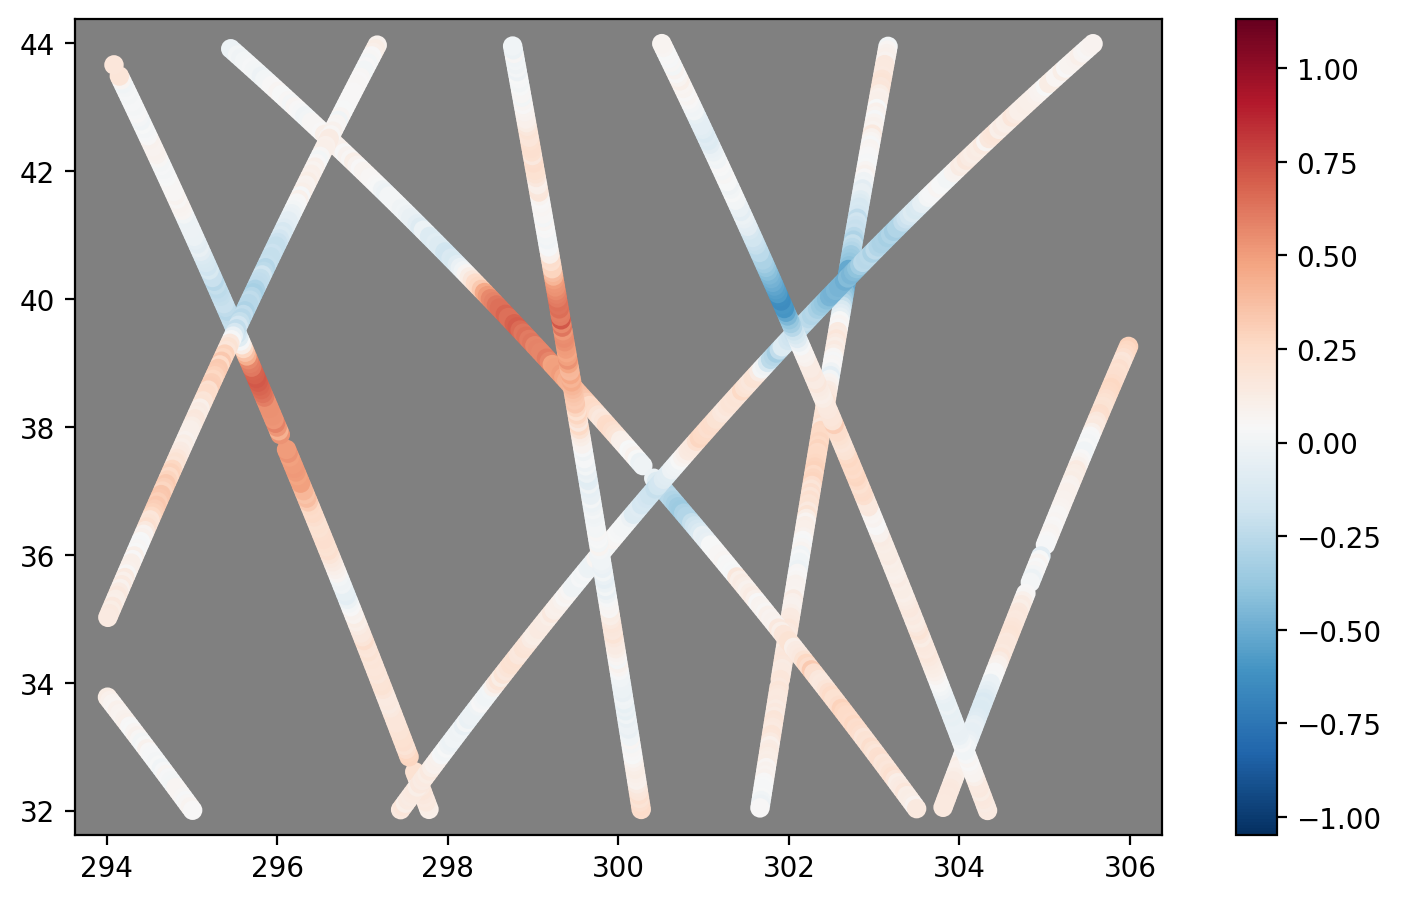

In [30]:
mov_custom.preview(9)

In [31]:
mov_custom.save(
    "plots/movie_ssh_gulf_jja_test.gif", 
    remove_movie=True,
    progress=True,
    framerate=5,
    gif_framerate=5,
    overwrite_existing=True,
)

  0%|          | 0/93 [00:00<?, ?it/s]

Movie created at test.mp4
GIF created at test.gif


In [46]:
def make_customplotfunc(ds_obs):
    def f(ds, fig, tt, *args, **kwargs):

        # find indices 
        indx = np.where(
            (
                np.abs(ds_obs.time.values - ds.time.values[tt]) <= dt
            )
        )[0]

        # subset data
        lat = ds_obs.latitude.values[indx]
        lon = ds_obs.longitude.values[indx]
        data = ds_obs.sla_unfiltered.values[indx]

        vmin = ds_obs.sla_unfiltered.min()
        vmax = ds_obs.sla_unfiltered.max()

        # do scatter plot
        ax = fig.add_subplot(111, aspect='equal')

        pts = ax.scatter(
            lon, lat, c=data, 
            cmap="RdBu_r", 
            vmin=ds_obs.sla_unfiltered.min(), 
            vmax=ds_obs.sla_unfiltered.max()
        )
        ax.set_title(f"{ds.time.values[tt]:.10}")
        ax.set_facecolor("0.5")
        ax.set_aspect(0.75)
        ax.set(
            xlim=[
                ds.longitude.values.min()-0.5,
                ds.longitude.values.max()+0.5
            ],
            ylim=[
                ds.latitude.values.min()-0.5,
                ds.latitude.values.max()+0.5,
            ],
            xlabel="Longitudes [degrees_east]",
            ylabel="Latitudes [degrees_north]",
        )
        plt.colorbar(pts)
        plt.tight_layout()

        return None, None
    
    return f
    
    

In [47]:
f_cust = make_customplotfunc(ds_test_obs_winter)

mov_custom = Movie(ds_winter.sla, f_cust)

/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


In [48]:
mov_custom.save(
    "plots/movie_ssh_gulf_djf_test.gif", 
    remove_movie=True,
    progress=True,
    framerate=5,
    gif_framerate=5,
    overwrite_existing=True,
)

  0%|          | 0/92 [00:00<?, ?it/s]

Movie created at movie_ssh_gulf_djf_test.mp4
GIF created at plots/movie_ssh_gulf_djf_test.gif


In [49]:
f_cust = make_customplotfunc(ds_test_obs_summer)

mov_custom = Movie(ds_summer.sla, f_cust)

/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


In [50]:
mov_custom.save(
    "plots/movie_ssh_gulf_jja_test.gif", 
    remove_movie=True,
    progress=True,
    framerate=5,
    gif_framerate=5,
    overwrite_existing=True,
)

  0%|          | 0/93 [00:00<?, ?it/s]

Movie created at movie_ssh_gulf_jja_test.mp4
GIF created at plots/movie_ssh_gulf_jja_test.gif


In [51]:
%%time

f_cust = make_customplotfunc(ds_train_obs_winter)

mov_custom = Movie(ds_winter.sla, f_cust)

/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


In [52]:
%%time

mov_custom.save(
    "plots/movie_ssh_gulf_djf_train.gif", 
    remove_movie=True,
    progress=True,
    framerate=5,
    gif_framerate=5,
    overwrite_existing=True,
)

  0%|          | 0/92 [00:00<?, ?it/s]

Movie created at movie_ssh_gulf_djf_train.mp4
GIF created at plots/movie_ssh_gulf_djf_train.gif
CPU times: user 1min 28s, sys: 23.9 s, total: 1min 52s
Wall time: 1min 24s


In [53]:
%%time

f_cust = make_customplotfunc(ds_train_obs_summer)

mov_custom = Movie(ds_summer.sla, f_cust)

/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:46: UserWarning: No `vmin` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmin` to avoid this step
  warnings.warn(
/home/johnsonj/miniconda3/envs/jax_cpu_py39/lib/python3.9/site-packages/xmovie/core.py:53: UserWarning: No `vmax` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `vmax` to avoid this step
  warnings.warn(


CPU times: user 10.2 s, sys: 308 ms, total: 10.5 s
Wall time: 10.1 s


In [54]:
%%time

mov_custom.save(
    "plots/movie_ssh_gulf_jja_train.gif", 
    remove_movie=True,
    progress=True,
    framerate=5,
    gif_framerate=5,
    overwrite_existing=True,
)

  0%|          | 0/93 [00:00<?, ?it/s]

Movie created at movie_ssh_gulf_jja_train.mp4
GIF created at plots/movie_ssh_gulf_jja_train.gif
CPU times: user 1min 33s, sys: 25.5 s, total: 1min 59s
Wall time: 1min 29s


In [417]:
df = pd.DataFrame(
    {"lat": lat, "lon": lon, "data": data})

In [428]:
df.hvplot.scatter(x="lon", y="lat", c="data", marker="o", size=100)

:Scatter   [lon]   (lat,data)

In [394]:
fig, ax = plt.subplots()

ax.scatter(lat, lon)
plt.show()

In [354]:
ds_summer.time.data[0]

numpy.datetime64('2016-06-01T00:00:00.000000000')

In [357]:
ds_test_obs_summer["time_stamps"] = ds_summer.time.data

In [364]:

dt

numpy.timedelta64(86400000000000,'ns')

In [365]:
dt = ds_summer.time.data[5] - ds_summer.time.data[4]
dt

numpy.timedelta64(86400000000000,'ns')

In [358]:
ds_test_obs_summer

<xarray.Dataset>
Dimensions:         (time: 71059, time_stamps: 93)
Coordinates:
  * time            (time) datetime64[ns] 2016-06-01T01:54:36.226493952 ... 2...
    longitude       (time) float64 295.9 295.9 295.9 295.9 ... 295.8 295.8 295.8
    latitude        (time) float64 32.04 32.1 32.16 32.22 ... 43.85 43.91 43.97
  * time_stamps     (time_stamps) datetime64[ns] 2016-06-01 ... 2016-09-01
Data variables:
    sla_unfiltered  (time) float32 0.007 -0.006 0.013 ... 0.151 0.127 0.142

In [366]:
ds_test_obs_summer.sel(time=slice(ds_summer.time.data[0] - 0.5 * dt, ds_summer.time.data[0] + 0.5 * dt))

<xarray.Dataset>
Dimensions:         (time: 310, time_stamps: 93)
Coordinates:
  * time            (time) datetime64[ns] 2016-06-01T01:54:36.226493952 ... 2...
    longitude       (time) float64 295.9 295.9 295.9 295.9 ... 305.2 305.2 305.2
    latitude        (time) float64 32.04 32.1 32.16 32.22 ... 32.16 32.1 32.04
  * time_stamps     (time_stamps) datetime64[ns] 2016-06-01 ... 2016-09-01
Data variables:
    sla_unfiltered  (time) float32 0.007 -0.006 0.013 ... 0.085 0.168 0.056

In [ ]:
def custom_plotfunc(ds, fig, tt, *args, **kwargs):
    
    
    return None, None

In [355]:
dt = ds_summer.time.data[1] - ds_summer.time.data[0]

numpy.timedelta64(86400000000000,'ns')

In [350]:
norm.min(), norm.max()

(<xarray.DataArray 'histogram_longitude_latitude_time' ()>
 array(-4.91600028),
 <xarray.DataArray 'histogram_longitude_latitude_time' ()>
 array(8.7840004))

In [351]:
# fig, ax = plt.subplots()
# norm.plot(x='longitude_bin', y='latitude_bin', vmax=0.2, ax=ax)
# plt.show()

In [352]:
norm.hvplot.image(x="longitude_bin", y="latitude_bin", cmap="RdBu_r")

:DynamicMap   [time_bin]
   :Image   [longitude_bin,latitude_bin]   (histogram_longitude_latitude_time)

In [208]:
# df_test_obs.hvplot.scatter(x="longitude", y="latitude", groupby='time', datashade=True)

In [209]:
norm

<xarray.DataArray 'histogram_longitude_latitude' (longitude_bin: 47, latitude_bin: 47)>
array([[ 38.24300182,  40.75200195,  32.44200143, ...,          nan,
                 nan,   0.        ],
       [ 71.52300324,  63.1960031 , 122.07100582, ...,          nan,
          5.69800025,   0.        ],
       [224.15501039, 214.56801015, 105.33500506, ...,  34.14600163,
         18.82000087,   1.24800008],
       ...,
       [ 70.47200317,  65.71000305,  30.98100148, ...,  44.70700214,
        155.19700746, 133.42800611],
       [ 37.30400179,  30.84700146,  31.27900149, ..., 102.18400452,
         77.18200361,  86.8950039 ],
       [ 65.46300314,  66.04300305,  42.92700206, ...,  35.79800163,
         41.76900172,  61.45300275]])
Coordinates:
  * longitude_bin  (longitude_bin) float64 294.2 294.5 294.8 ... 305.5 305.8
  * latitude_bin   (latitude_bin) float64 32.25 32.5 32.75 ... 43.25 43.5 43.75

In [269]:
base_ds = ds_summer.sortby("time")
new_ds = ds_test_obs_summer.sortby("time").dropna(dim="time")

In [257]:
new_ds

<xarray.Dataset>
Dimensions:         (time: 71059)
Coordinates:
  * time            (time) datetime64[ns] 2016-06-01T01:54:36.226493952 ... 2...
    longitude       (time) float64 295.9 295.9 295.9 295.9 ... 295.8 295.8 295.8
    latitude        (time) float64 32.04 32.1 32.16 32.22 ... 43.85 43.91 43.97
Data variables:
    sla_unfiltered  (time) float32 0.007 -0.006 0.013 ... 0.151 0.127 0.142

In [86]:
new_ds.sortby("time")

<xarray.Dataset>
Dimensions:         (time: 71059)
Coordinates:
  * time            (time) datetime64[ns] 2016-06-01T01:54:36.226493952 ... 2...
    longitude       (time) float64 295.9 295.9 295.9 295.9 ... 295.8 295.8 295.8
    latitude        (time) float64 32.04 32.1 32.16 32.22 ... 43.85 43.91 43.97
Data variables:
    sla_unfiltered  (time) float32 0.007 -0.006 0.013 ... 0.151 0.127 0.142

In [99]:
new_ds.longitude.values.shape, new_ds.latitude.values.shape, new_ds.time.values.shape

((71059,), (71059,), (71059,))

In [261]:
np.isnan(var).sum()

372

In [100]:
# create axis
lon_axis = pyinterp.Axis(base_ds["longitude"][:].data, is_circle=True)
lat_axis = pyinterp.Axis(base_ds["latitude"][:].data)
t_axis = pyinterp.TemporalAxis(base_ds["time"][:].data)

# get data variable
var = base_ds["sla"].transpose("longitude", "latitude", "time").data


# create grid
grid = pyinterp.Grid3D(lon_axis, lat_axis, t_axis, var)

# interpolate maps onto along track dataset
obs_interp = pyinterp.trivariate(
    grid,
    new_ds.longitude.values,
    new_ds.latitude.values,
    t_axis.safe_cast(new_ds.time.values),
    bounds_error=False
    # ds_obs.sla_unfiltered.values
)
print(obs_interp.shape)

(71059,)


In [189]:
t = new_ds.resample(time="1D").mean()

In [190]:
t

<xarray.Dataset>
Dimensions:         (time: 93)
Coordinates:
  * time            (time) datetime64[ns] 2016-06-01 2016-06-02 ... 2016-09-01
Data variables:
    sla_unfiltered  (time) float32 0.04879 0.07225 0.06628 ... 0.1775 0.2505

In [270]:
base_ds = ds_summer.sortby("time")
new_ds = ds_test_obs_summer.sortby("time").dropna(dim="time")

In [271]:
from scipy.interpolate import griddata

In [272]:
base_ds.longitude.values.shape, base_ds.latitude.values.shape, base_ds.time.values.astype(np.float64).shape

((48,), (48,), (93,))

In [273]:
grid = np.meshgrid(base_ds.longitude.values, base_ds.latitude.values, base_ds.time.values.astype(np.float64))
grid[0].shape, grid[1].shape, grid[2].shape

((48, 48, 93), (48, 48, 93), (48, 48, 93))

In [274]:
new_ds.sla_unfiltered.shape, np.stack([new_ds.longitude.values, new_ds.latitude.values, new_ds.time.values.astype(np.float64)], axis=1).shape

((70946,), (70946, 3))

In [275]:
new_ds

<xarray.Dataset>
Dimensions:         (time: 70946)
Coordinates:
  * time            (time) datetime64[ns] 2016-06-01T01:54:36.226493952 ... 2...
    longitude       (time) float64 295.9 295.9 295.9 295.9 ... 295.8 295.8 295.8
    latitude        (time) float64 32.04 32.1 32.16 32.22 ... 43.85 43.91 43.97
Data variables:
    sla_unfiltered  (time) float32 0.007 -0.006 0.013 ... 0.151 0.127 0.142

In [278]:
%%time

grid_z0 = griddata(
    np.stack([new_ds.longitude.values, new_ds.latitude.values, new_ds.time.values.astype(np.float64)], axis=1), 
    new_ds.sla_unfiltered,
    (grid[0], grid[1], grid[2]), 
    method='nearest', 
)

CPU times: user 232 ms, sys: 0 ns, total: 232 ms
Wall time: 231 ms


In [279]:
grid_z0

array([[[0.007     , 0.001     , 0.15400001, ..., 0.012     ,
         0.18200001, 0.17500001],
        [0.007     , 0.001     , 0.15400001, ..., 0.012     ,
         0.18200001, 0.17500001],
        [0.007     , 0.001     , 0.15400001, ..., 0.012     ,
         0.18200001, 0.17500001],
        ...,
        [0.007     , 0.001     , 0.15400001, ..., 0.012     ,
         0.18200001, 0.17500001],
        [0.007     , 0.001     , 0.15400001, ..., 0.012     ,
         0.18200001, 0.17500001],
        [0.007     , 0.001     , 0.15400001, ..., 0.012     ,
         0.18200001, 0.17500001]],

       [[0.007     , 0.001     , 0.15400001, ..., 0.012     ,
         0.18200001, 0.17500001],
        [0.007     , 0.001     , 0.15400001, ..., 0.012     ,
         0.18200001, 0.17500001],
        [0.007     , 0.001     , 0.15400001, ..., 0.012     ,
         0.18200001, 0.17500001],
        ...,
        [0.007     , 0.001     , 0.15400001, ..., 0.012     ,
         0.18200001, 0.17500001],
        [0.0

In [239]:
grid_z0.shape

(48, 48, 93)

In [280]:
base_ds["tracks"] = (("longitude", "latitude", "time"), grid_z0)

In [281]:
base_ds

<xarray.Dataset>
Dimensions:    (latitude: 48, longitude: 48, time: 93)
Coordinates:
  * time       (time) datetime64[ns] 2016-06-01 2016-06-02 ... 2016-09-01
  * latitude   (latitude) float64 32.12 32.38 32.62 32.88 ... 43.38 43.62 43.88
  * longitude  (longitude) float64 294.1 294.4 294.6 294.9 ... 305.4 305.6 305.9
Data variables:
    sla        (time, latitude, longitude) float64 0.03442 0.03972 ... 0.1244
    adt        (time, latitude, longitude) float64 ...
    sla_grad   (time, latitude, longitude) float64 0.003422 ... 0.001681
    sla_lap    (time, latitude, longitude) float64 0.0009892 ... 0.0003708
    tracks     (longitude, latitude, time) float32 0.007 0.001 ... 0.182 0.175
Attributes:
    FileType:      GRID_DOTS
    OriginalName:  dt_upd_global_merged_msla_h_20150101_20150101_20210409.nc
    CreatedBy:     pva_axp@node065.sis.cnes.fr
    CreatedOn:     09-APR-2021 17:15:56:000000
    title:         SSALTO/DUACS - DT MSLA - Merged Product - Up-to-date Globa...
    history:       2021/04/09 17:15:56 pva_axp@node065.sis.cnes.fr Import dep...

In [247]:
base_ds.sla.hvplot.image(x="longitude", y="latitude", width=500, height=400, cmap="RdBu_r", title="Data")

:DynamicMap   [time]
   :Image   [longitude,latitude]   (sla)

In [282]:
base_ds.tracks.hvplot.image(x="longitude", y="latitude", width=500, height=400, cmap="RdBu_r", title="Data")

:DynamicMap   [time]
   :Image   [longitude,latitude]   (tracks)

In [173]:
t = np.stack([new_ds.longitude.values, new_ds.latitude.values, new_ds.time.values.astype(np.float64)], axis=1)
new_ds.sla_unfiltered.shape, t.shape

((71059,), (71059, 3))

In [174]:
base_ds.longitude.values.shape, base_ds.latitude.values.shape, base_ds.time.values.shape

((48,), (48,), (93,))

In [122]:
new_lon = new_ds.longitude.values[~np.isnan(obs_interp)]
new_lat = new_ds.latitude.values[~np.isnan(obs_interp)]
new_time = new_ds.time.values[~np.isnan(obs_interp)]
new_var = new_ds.sla_unfiltered.values[~np.isnan(obs_interp)]
new_lon.shape

(67622,)

In [158]:
type(new_time[0])

numpy.datetime64

In [147]:
df = pd.DataFrame(
    {
        "latitude": new_lat,
        "longitude": new_lon,
        "time": new_time,
        "sla": new_var
    })
df = df.set_index(["time", "latitude", "longitude"])

df = df.groupby(level="time").sla.rolling("1d").mean()

ValueError: window must be an integer

In [ ]:
df.head()

KeyError: 'Column not found: 0'

In [144]:
df = df.groupby([df.index.get_level_values('time').("1D").mean(),'latitude', 'longitude'])


AttributeError: 'DatetimeIndex' object has no attribute 'rolling'

In [133]:
df.index

MultiIndex([( 1,          32.136641,         296.352314),
            ( 1,          32.137024,         297.160732),
            ( 1,          32.139514,           303.4935),
            ( 1,          32.145274, 301.96531999999996),
            ( 1,           32.14859,         297.763541),
            ( 1, 32.154185999999996,         297.292374),
            ( 1,          32.159115,         305.171702),
            ( 1,          32.160401,         295.324728),
            ( 1,           32.16061,         295.869553),
            ( 1,          32.163703, 301.67814599999997),
            ...
            (31, 43.792556999999995,         305.240139),
            (31,          43.800162, 297.09549699999997),
            (31,          43.811009,         298.373785),
            (31, 43.813790999999995,         304.082563),
            (31, 43.836850999999996, 301.58691999999996),
            (31,          43.849587, 305.24794099999997),
            (31,          43.849868,         295.405978)

In [ ]:
xr.op

In [116]:
t = df.set_index(["time", "latitude", "longitude"]).to_xarray()

MemoryError: Unable to allocate 70.4 GiB for an array with shape (3437, 2346, 2344) and data type float32

In [109]:
new_lon.min(), new_lon.max()

(294.126099, 305.874995)

In [106]:
grid.array.shape

(48, 48, 93)

In [ ]:
pyinterp.B